In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [4]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))


853
853
683
683
170
170


In [5]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time


In [6]:
def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]


adjust_label = 1


def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label


def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target


def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1, 2, 0)

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1:
            rect = patches.Rectangle(
                (xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='r', facecolor='none')

        elif annotation['labels'][idx] == 2:

            rect = patches.Rectangle(
                (xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='g', facecolor='none')

        else:
    
            rect = patches.Rectangle(
                (xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='orange', facecolor='none')

        ax.add_patch(rect)

    plt.show()


In [7]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))

    def __getitem__(self, idx):  # special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
    transforms.ToTensor()  # ToTensor : numpy 이미지에서 torch 이미지로 변경
])


def collate_fn(batch):
    return tuple(zip(*batch))


dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=2, collate_fn=collate_fn)


In [8]:
def get_model_instance_segmentation(num_classes):
      
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [9]:
model = get_model_instance_segmentation(4)

device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/joo/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 102MB/s]  


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [10]:
torch.cuda.is_available()


True

In [11]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)


In [12]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()}
                       for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(
        f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')


----------------------train start--------------------------


/home/joo/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch : 1, Loss : 71.56696319580078, time : 118.0846848487854
epoch : 2, Loss : 48.474605560302734, time : 126.0747663974762
epoch : 3, Loss : 41.38981628417969, time : 132.1752438545227
epoch : 4, Loss : 35.59613800048828, time : 130.94470143318176
epoch : 5, Loss : 32.24703598022461, time : 134.03096318244934
epoch : 6, Loss : 31.168405532836914, time : 135.8216414451599
epoch : 7, Loss : 30.256668090820312, time : 131.58466958999634
epoch : 8, Loss : 30.039918899536133, time : 140.62010407447815
epoch : 9, Loss : 25.710771560668945, time : 139.43559741973877
epoch : 10, Loss : 23.763526916503906, time : 139.3990716934204


In [13]:
torch.save(model.state_dict(), f'model_{num_epochs}.pt')


In [14]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))


<All keys matched successfully>

In [15]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)):
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']):
            if score > threshold:
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds


In [16]:
with torch.no_grad():
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break


[{'boxes': tensor([[213.0625,  59.3245, 253.4236, 100.0997],
        [118.1875,   2.2196, 132.9390,  18.9208]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9695, 0.9230], device='cuda:0')}, {'boxes': tensor([[218.1169,  99.6811, 257.7624, 139.2130],
        [131.5425, 109.7115, 178.4097, 152.4495],
        [ 41.1120, 109.2993,  67.4492, 140.4468],
        [302.6152, 130.6645, 332.2178, 158.9878],
        [ 83.5087,  84.5702,  94.4782,  96.3777],
        [ 29.7529,  89.3118,  45.1900, 103.5625],
        [164.8297,  90.4901, 179.1562, 108.4876],
        [  2.0321, 104.5187,  21.3657, 127.8816],
        [257.4293,  90.9131, 268.4970, 101.6916]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.9948, 0.9940, 0.9905, 0.9904, 0.9877, 0.9815, 0.9564, 0.6919],
       device='cuda:0')}]


Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


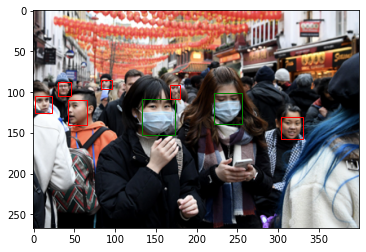

Prediction :  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

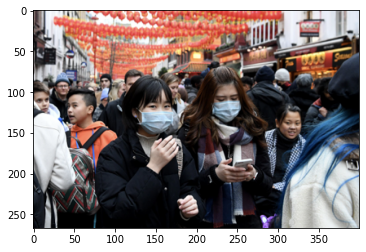

In [17]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])


In [18]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position=0, leave=True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu'))
                      for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 85/85 [00:12<00:00,  6.93it/s]


In [19]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/home/joo/Desktop/joo/src/visual-studioCode-workspaceses/faster_R_CNN/source/test/Tutorial-Book-Utils


In [20]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(
        preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [
    torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(
    true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')


mAP : 0.7654097811273539
AP : tensor([0.8685, 0.9277, 0.5000], dtype=torch.float64)
